In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm


/tmp/ipykernel_3358932/2806640137.py:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
L = upper - lower
x = jnp.linspace(0, 1, 1000)
boundary = jnp.array([[lower, upper]]).T
boundary_conditions = jnp.zeros(shape = (2, )) # Dirichlet boundary conditions
domain = jnp.array([lower, upper])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
n_meas = 2**3
n_quad = 5
n_meas

8

In [4]:
epsilon = (upper- lower)/n_meas

In [5]:
centers = jnp.linspace(lower, upper, n_meas + 1)
epsilon = (upper - lower)/n_meas
epsilon_values  = jnp.ones(n_meas)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

In [6]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

In [7]:
x_q, w_q = roots_legendre(n_quad)
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)

In [8]:
# def tent_element(x, epsilon, interval):
#     lower, upper = interval
#     element = jnp.maximum(0, 1 + (x - upper) / epsilon)/epsilon#jnp.maximum(0, 1 - (x - lower) / epsilon)/epsilon
    

#     # Set the element to zero outside the interval
#     element = jnp.where(x < lower, 0.0, element)
#     element = jnp.where(x > upper, 0.0, element)

#     return element

In [9]:
# x = jnp.linspace(0, 1, 1000)
# element= tent_element(x, epsilon, intervals[0])

# plt.plot(x, element, label = 'element')
# plt.legend()

In [11]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

In [15]:
tent_element(x_element, normalization = epsilon), tent_element(jnp.linspace(0,1,10))

(Array([0.37528062, 1.84612276, 4.        , 6.15387724, 7.62471938],      dtype=float64),
 Array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ],      dtype=float64))

In [16]:
def f(x):
    return jnp.sin(jnp.pi*x)

In [17]:
x_quad

Array([[0.00586376, 0.02884567, 0.0625    , 0.09615433, 0.11913624],
       [0.13086376, 0.15384567, 0.1875    , 0.22115433, 0.24413624],
       [0.25586376, 0.27884567, 0.3125    , 0.34615433, 0.36913624],
       [0.38086376, 0.40384567, 0.4375    , 0.47115433, 0.49413624],
       [0.50586376, 0.52884567, 0.5625    , 0.59615433, 0.61913624],
       [0.63086376, 0.65384567, 0.6875    , 0.72115433, 0.74413624],
       [0.75586376, 0.77884567, 0.8125    , 0.84615433, 0.86913624],
       [0.88086376, 0.90384567, 0.9375    , 0.97115433, 0.99413624]],      dtype=float64)

In [65]:
def f(x):
    return jnp.sin(4*jnp.pi*x)

def f(x):
    return x**3 -1 -x + 0.02*jnp.sin(2*jnp.pi*x)

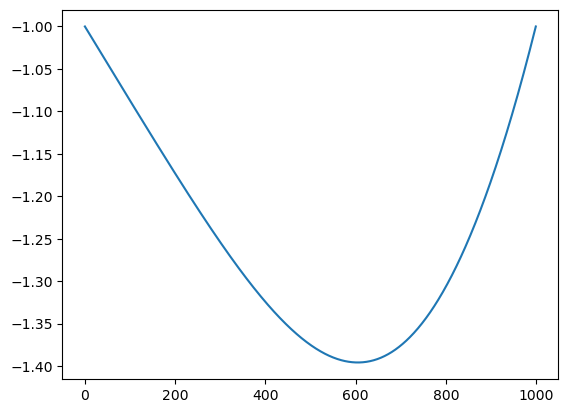

In [66]:
f_quad = f(x_quad)

x = jnp.linspace(0, 1, 1000)
plt.plot(f(x))

In [67]:
def project_tent_basis(f, element, w_quad, include_boundary):

    F_1 = jnp.sum(f*element*w_quad, axis = 1)
    F_2 = jnp.sum(f*element[::-1]*w_quad, axis = 1)

    if include_boundary:
        result = jnp.hstack([F_2[0], F_1[:-1] + F_2[1:], F_1[-1]])
    else:
        result = F_1[:-1] + F_2[1:]

    return result

In [68]:
element_quad = tent_element(x_element, normalization = epsilon)

In [69]:
project_tent_basis(f_quad, element_quad, w_quad, True)

Array([-0.51819725, -1.10864036, -1.21342905, -1.30590598, -1.37109375,
       -1.38940652, -1.34125845, -1.21167214, -0.5403965 ], dtype=float64)

In [70]:
jnp.sum(f_quad[0]*element_quad[::-1]*w_quad[0], axis = -1), jnp.sum(f_quad[-1]*element_quad*w_quad[-1], axis = -1)

(Array(-0.51819725, dtype=float64), Array(-0.5403965, dtype=float64))

In [71]:
i = 2
jnp.sum(f_quad[i]*element_quad*w_quad[i], axis = -1)+ jnp.sum(f_quad[i+1]*element_quad[::-1]*w_quad[i+1], axis = -1)

Array(-1.30590598, dtype=float64)

In [72]:
from scipy import integrate

In [73]:
def tent_function(x, epsilon, center):
    return jnp.maximum(0, 1 - jnp.abs(x - center) / epsilon)/epsilon


i = 3
f_integrate = lambda x: f(x)*tent_function(x, epsilon, centers[i])
integrate.quad(f_integrate, centers[i-1], centers[i+1])

(-1.3059059828054878, 1.454392162258955e-14)

In [74]:
i = 1
f_integrate = lambda x: f(x)*tent_function(x, epsilon, centers[i-1])
integrate.quad(f_integrate, centers[i-1], centers[i])

(-0.5181972529186603, 5.7531452148780225e-15)

In [75]:
i = 8
f_integrate = lambda x: f(x)*tent_function(x, epsilon, centers[i])
integrate.quad(f_integrate, centers[i-1], centers[i])

(-0.5403964970813396, 5.999606334864845e-15)

In [78]:
project_tent_basis(f_quad, element_quad, w_quad, True)

Array([-0.51819725, -1.10864036, -1.21342905, -1.30590598, -1.37109375,
       -1.38940652, -1.34125845, -1.21167214, -0.5403965 ], dtype=float64)

In [77]:
centers

Array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ],      dtype=float64)